In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import  DataLoader
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
batchSize = 64

def get_train_valid_loader(data_dir, batch_size, augment, random_seed, valid_size = 0.1, shuffle = True):
  normalize = transforms.Normalize(mean = [0.4914, 0.4822, 0.4465],
                                   std = [0.2023, 0.1994, 0.2010])
  valid_transform = transforms.Compose([
      transforms.Resize((227,227)),
      transforms.ToTensor(),
      normalize
  ])
  if augment:
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
  else:
    train_transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    normalize,
  ])

  train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True,download=True, transform=train_transform, )

  valid_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=valid_transform, )

  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))


  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

def get_test_loader(data_dir,  batch_size, shuffle=True):
  normalize = transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225],
  )

  # define transform
  transform = transforms.Compose([
      transforms.Resize((227,227)),
      transforms.ToTensor(),
      normalize,
  ])

  dataset = torchvision.datasets.CIFAR10(
      root=data_dir, train=False,
      download=True, transform=transform,
  )

  data_loader = torch.utils.data.DataLoader(
      dataset, batch_size=batch_size, shuffle=shuffle
  )

  return data_loader

In [6]:
train_loader, valid_loader = get_train_valid_loader(data_dir = './Cifar10', batch_size = batchSize, augment = False,random_seed = 1)

test_loader = get_test_loader(data_dir = './Cifar10', batch_size = batchSize)

100%|██████████| 170M/170M [00:02<00:00, 67.0MB/s]


In [7]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

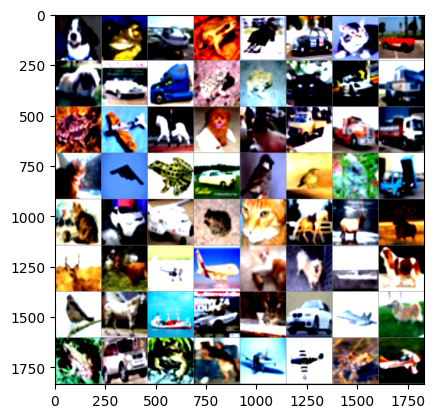

dog   frog  plane frog  horse car   cat   car   dog   car   truck frog  frog  cat   car   truck frog  plane horse dog   dog   truck truck truck cat   plane frog  car   bird  bird  cat   truck cat   car   plane frog  cat   horse deer  deer  deer  deer  plane plane cat   dog   ship  dog   bird  horse ship  car   cat   car   plane dog   frog  car   frog  dog   plane plane frog  plane


In [10]:
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

In [14]:
class AlexNet(nn.Module):
  def __init__(self, num_classess = 10):
    super(AlexNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size = 11, stride = 4, padding = 0),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(96, 256, kernel_size = 5, stride = 1, padding = 2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(256, 384, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(384),
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Conv2d(384, 384, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(384),
        nn.ReLU()
    )
    self.layer5 = nn.Sequential(
        nn.Conv2d(384, 256, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2)
    )
    self.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(9216, 4096),
        nn.ReLU(),
    )
    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
    )
    self.fc2 = nn.Sequential(
        nn.Linear(4096, num_classess)
    )
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [16]:
num_classes = 10
num_epochs = 20
learning_rate = 0.005

model = AlexNet(num_classes).to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = 0.005, momentum = 0.9)
total_step = len(train_loader)

In [19]:
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    #Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

  # Validation
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      del images, labels, outputs

    print(f'Accuracy of the netowrk on 5000 validation images : {100 * correct/ total}')

Epoch [1/20], Step [704/704], Loss: 0.9919
Accuracy of the netowrk on 5000 validation images : 60.03
Epoch [2/20], Step [704/704], Loss: 0.4586
Accuracy of the netowrk on 5000 validation images : 69.81
Epoch [3/20], Step [704/704], Loss: 0.6277
Accuracy of the netowrk on 5000 validation images : 71.78
Epoch [4/20], Step [704/704], Loss: 0.7754
Accuracy of the netowrk on 5000 validation images : 73.64
Epoch [5/20], Step [704/704], Loss: 0.6561
Accuracy of the netowrk on 5000 validation images : 75.31
Epoch [6/20], Step [704/704], Loss: 0.8745
Accuracy of the netowrk on 5000 validation images : 77.68
Epoch [7/20], Step [704/704], Loss: 0.1603
Accuracy of the netowrk on 5000 validation images : 78.34
Epoch [8/20], Step [704/704], Loss: 0.2769
Accuracy of the netowrk on 5000 validation images : 78.8
Epoch [9/20], Step [704/704], Loss: 0.6248
Accuracy of the netowrk on 5000 validation images : 79.13
Epoch [10/20], Step [704/704], Loss: 0.7785
Accuracy of the netowrk on 5000 validation image

In [20]:
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    del images, labels, outputs

  print(f'Accuracy of the network on the 10000 test images: {100 * correct/ total}')

Accuracy of the network on the 10000 test images: 81.61


In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 78 %
Accuracy of   car : 93 %
Accuracy of  bird : 69 %
Accuracy of   cat : 72 %
Accuracy of  deer : 80 %
Accuracy of   dog : 64 %
Accuracy of  frog : 91 %
Accuracy of horse : 88 %
Accuracy of  ship : 91 %
Accuracy of truck : 82 %
